# Liver Transplant Center Performance EDA

This notebook first collects liver transplant center data from SRTR Program-Specific Reports (data previously harvested from PDF files and stored in CSV files, one CSV per center). Specific performance metrics are collected into a dataframe for EDA.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import re
import datetime
import camelot
import json
import zipfile
import os

from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

In [2]:
# Function for collecting data values from first page header
def header(csv_name, df):
    code = csv_name[0:4]
    with open(csv_name, 'r') as file:
        line = file.readline()
        
    #get first string on line
    df.loc[code, 'CenterName'] = line.split(',')[0]


In [3]:
# Function for collecting data values from Table B1
def table_b1_2019(csv_name, df):
    table = pd.read_csv(csv_name, skiprows=9)
    code = csv_name[0:4]
    df.loc[code,'WL_start_2017'] = int(table.loc[0,'12/31/2017'])
    df.loc[code,'WL_adds_2017'] = int(table.loc[2,'12/31/2017'])
    df.loc[code,'WL_xfer_2017'] = int(table.loc[4,'12/31/2017']) + int(table.loc[8,'12/31/2017'])
    df.loc[code,'WL_xplant_2017'] = int(table.loc[5,'12/31/2017']) + int(table.loc[6,'12/31/2017'])
    df.loc[code,'WL_died_2017'] = int(table.loc[7,'12/31/2017'])
    df.loc[code,'WL_deter_2017'] = int(table.loc[9,'12/31/2017'])
    df.loc[code,'WL_recov_2017'] = int(table.loc[10,'12/31/2017'])
    df.loc[code,'WL_other_2017'] = int(table.loc[11,'12/31/2017'])
    
    # Collect values for 2018
    df.loc[code,'WL_start_2018'] = int(table.loc[0,'12/31/2018'])
    df.loc[code,'WL_adds_2018'] = int(table.loc[2,'12/31/2018'])
    df.loc[code,'WL_xfer_2018'] = int(table.loc[4,'12/31/2018']) + int(table.loc[8,'12/31/2018'])
    df.loc[code,'WL_xplant_2018'] = int(table.loc[5,'12/31/2018']) + int(table.loc[6,'12/31/2018'])
    df.loc[code,'WL_died_2018'] = int(table.loc[7,'12/31/2018'])
    df.loc[code,'WL_deter_2018'] = int(table.loc[9,'12/31/2018'])
    df.loc[code,'WL_recov_2018'] = int(table.loc[10,'12/31/2018'])
    df.loc[code,'WL_other_2018'] = int(table.loc[11,'12/31/2018'])


In [4]:
# Function for collecting data values from Table B1
def table_b1_2018(csv_name, df):
    table = pd.read_csv(csv_name, skiprows=9)
    code = csv_name[0:4]
    df.loc[code,'WL_start_2016'] = int(table.loc[0,'12/31/2016'])
    df.loc[code,'WL_adds_2016'] = int(table.loc[2,'12/31/2016'])
    df.loc[code,'WL_xfer_2016'] = int(table.loc[4,'12/31/2016']) + int(table.loc[8,'12/31/2016'])
    df.loc[code,'WL_xplant_2016'] = int(table.loc[5,'12/31/2016']) + int(table.loc[6,'12/31/2016'])
    df.loc[code,'WL_died_2016'] = int(table.loc[7,'12/31/2016'])
    df.loc[code,'WL_deter_2016'] = int(table.loc[9,'12/31/2016'])
    df.loc[code,'WL_recov_2016'] = int(table.loc[10,'12/31/2016'])
    df.loc[code,'WL_other_2016'] = int(table.loc[11,'12/31/2016'])
    

In [5]:
# Function for collecting data values from Table B4
def table_b4(csv_name, df):
    table = pd.read_csv(csv_name, skiprows=2)
    code = csv_name[0:4]
    df.loc[code,'WL_start_2016'] = int(table.loc[0,'12/31/2016'])

In [6]:
# Function for collecting data values from Table B10
def table_b10_2019(csv_name, df):
    table = pd.read_csv(csv_name, skiprows=3)
    code = csv_name[0:4]
    df.loc[code,'OfferAcceptRatio'] = float(table.loc[4,'This Center'])
    

In [7]:
# Function for collecting data values from Table C6
def table_c6_2019(csv_name, df):
    table = pd.read_csv(csv_name, skiprows=9)
    code = csv_name[0:4]
    num = re.search(r'^\d+',table.iloc[0,1])
    if num != None:
        df.loc[code,'TR_1yr_eval'] = int(num.group())
    else:
        print('Problem in table_c6: value for TR_1y_eval not found')
        
    num = re.search(r'^\d+.\d+',table.iloc[2,1])
    if num != None:
        df.loc[code,'TR_1yr_surv'] = float(num.group())/100
    else:
        print('Problem in table_c6: value for TR_1y_surv not found')

In [8]:
# Function for collecting data values from Table C2D
def table_c2d(csv_name, df):
    table = pd.read_csv(csv_name, skiprows=4)
    code = csv_name[0:4]
    df.loc[code,'TR_meld_6-10'] = float(table.loc[27,'Center'])
    df.loc[code,'TR_meld_11-14'] = float(table.loc[28,'Center'])
    df.loc[code,'TR_meld_15-20'] = float(table.loc[29,'Center'])
    df.loc[code,'TR_meld_21-30'] = float(table.loc[30,'Center'])
    df.loc[code,'TR_meld_31-40'] = float(table.loc[31,'Center'])
    df.loc[code,'TR_status1A'] = float(table.loc[25,'Center'])

In [9]:
# Function for collecting data values from table B3
def table_b9(csv_name, df):
    table = pd.read_csv(csv_name, skiprows=4)
    code = csv_name[0:4]
    try:
        df.loc[code,'median_time_to_xplant'] = float(table.loc[3,'Center'])
    except:
        df.loc[code,'median_time_to_xplant'] = np.NaN


In [10]:
# Get a list of center codes to use as the index for the dataframe
#directory_2019 = 'reports_07-2019\\socal\\'
directory_2019 = 'reports_07-2019\\'
#directory_2018 = 'reports_10-2018\\socal\\'
directory_2018 = 'reports_10-2018\\'

center_list_2019 = []
center_list_2018 = []

for filename in os.listdir(directory_2019):
    if filename.endswith(".zip"):
        center_list_2019.append(filename[0:4])
        
for filename in os.listdir(directory_2018):
    if filename.endswith(".zip"):
        center_list_2018.append(filename[0:4])
        
# List of files in the two folders are not the same because 2019 files were manually downloaded so don't include centers with 
#     no adult patients. Need to remove these files from the 2018 folder.

print(set(center_list_2019).symmetric_difference(set(center_list_2018)))

#print(center_list_2019)
#print(center_list_2018)

set()


In [11]:
# Build dataframe from data extracted from pdf (csv files in compressed folders)
# start by reconstructing the df constructed manually as to develop/test code

table_list = ['-page-1-table-1.csv','-page-6-table-1.csv','-page-17-table-1.csv','-page-30-table-1.csv','-page-16-table-1.csv','-page-21-table-1.csv']

# setup dataframe
liver_centers = pd.DataFrame(columns=['CenterName','WL_start_2018','WL_start_2017','WL_start_2016',
                                      'WL_adds_2018','WL_adds_2017','WL_adds_2016','WL_xfer_2018','WL_xfer_2017',
                                      'WL_xfer_2016','WL_xplant_2018','WL_xplant_2017','WL_xplant_2016','WL_died_2018',
                                      'WL_died_2017','WL_died_2016','WL_deter_2018','WL_deter_2017','WL_deter_2016',
                                      'WL_recov_2018','WL_recov_2017','WL_recov_2016','WL_other_2018','WL_other_2017',
                                      'WL_other_2016','TR_1yr_eval','TR_1yr_surv','TR_succ','Metric','OfferAcceptRatio',
                                      'median_time_to_xplant','TR_meld_6-10','TR_meld_11-14','TR_meld_15-20''TR_meld_21-30',
                                      'TR_meld_31-40','TR_status1A'],
                            index=center_list_2019)

for filename in os.listdir(directory_2019):

    if filename.endswith(".zip"):
        center_code = filename[0:4]
        print(center_code)
        path_filename = directory_2019 + filename
        archive = zipfile.ZipFile(path_filename)
        
        # extract csv files with tables containing needed data from archive
        csv_name = []
        for i in range(len(table_list)):
            csv_name.append(filename[:-4] + table_list[i])
            archive.extract(csv_name[i], '.')
            
#        print (csv_name[0], csv_name[1], csv_name[2], csv_name[3])
        
        # collect data from extracted csv files
        header(csv_name[0], liver_centers)
        table_b1_2019(csv_name[1], liver_centers)
        table_b10_2019(csv_name[2], liver_centers)
        table_c6_2019(csv_name[3], liver_centers)
        table_b9(csv_name[4], liver_centers)
        table_c2d(csv_name[5], liver_centers)
        
        
        # delete the extracted files
        for i in range(len(table_list)):
            os.remove(csv_name[i])



ALUA
ARUA
AZGS
AZMC
AZSJ
AZUA
CACL
CACS
CAGH
CALL
CAPC
CAPM
CASD
CASF
CASU
CAUC
CAUH
COPM
COSL
COUC
CTHH
CTYN
DCGU
FLBC
FLCC
FLFH
FLJM
FLLM
FLSL
FLTG
FLUF
GAEH
GAEM
GAPH
HIQM
IAIV
ILLU
ILNM
ILPL
ILUC
ILUI
INIM
KSUK
KYJH
KYUK
LAOF
LATU
LAWK
MABI
MALC
MAMG
MAUM
MDJH
MDUM
MIBH
MIHF
MIUM
MNMC
MNUM
MOBH
MOLH
MOSL
MSUM
NCCM
NCDU
NCMH
NEUN
NJLL
NJUH
NYCP
NYFL
NYMA
NYMS
NYNY
NYUC
NYWC
OHCC
OHCM
OHOU
OHUC
OHUH
OKBC
ORUO
ORVA
PAAE
PAAG
PACH
PAGM
PAHE
PAHM
PAPT
PATJ
PATU
PAUP
PAVA
PRSJ
SCMU
SDMK
TNMH
TNVU
TXAS
TXBC
TXHH
TXHI
TXHS
TXJS
TXMC
TXMH
TXPL
TXSP
TXTC
TXTX
TXVA
UTLD
UTMC
VAMC
VAUV
WASM
WAUW
WISE
WISL
WIUW


In [12]:
# Continue with 2018 files (extracting data for 2016)
for filename in os.listdir(directory_2018):

    if filename.endswith(".zip"):
        center_code = filename[0:4]
        print(center_code)
        path_filename = directory_2018 + filename
        archive = zipfile.ZipFile(path_filename)
        
        # only need one of csv files processed for 2019
        csv_table_b1 = filename[:-4] + table_list[1]
        archive.extract(csv_table_b1, '.')
            
        # collect data from extracted csv file
        table_b1_2018(csv_table_b1, liver_centers)
        
        # delete the extracted file
        os.remove(csv_table_b1)


ALUA
ARUA
AZGS
AZMC
AZSJ
AZUA
CACL
CACS
CAGH
CALL
CAPC
CAPM
CASD
CASF
CASU
CAUC
CAUH
COPM
COSL
COUC
CTHH
CTYN
DCGU
FLBC
FLCC
FLFH
FLJM
FLLM
FLSL
FLTG
FLUF
GAEH
GAEM
GAPH
HIQM
IAIV
ILLU
ILNM
ILPL
ILUC
ILUI
INIM
KSUK
KYJH
KYUK
LAOF
LATU
LAWK
MABI
MALC
MAMG
MAUM
MDJH
MDUM
MIBH
MIHF
MIUM
MNMC
MNUM
MOBH
MOLH
MOSL
MSUM
NCCM
NCDU
NCMH
NEUN
NJLL
NJUH
NYCP
NYFL
NYMA
NYMS
NYNY
NYUC
NYWC
OHCC
OHCM
OHOU
OHUC
OHUH
OKBC
ORUO
ORVA
PAAE
PAAG
PACH
PAGM
PAHE
PAHM
PAPT
PATJ
PATU
PAUP
PAVA
PRSJ
SCMU
SDMK
TNMH
TNVU
TXAS
TXBC
TXHH
TXHI
TXHS
TXJS
TXMC
TXMH
TXPL
TXSP
TXTC
TXTX
TXVA
UTLD
UTMC
VAMC
VAUV
WASM
WAUW
WISE
WISL
WIUW


In [13]:
liver_centers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, ALUA to WIUW
Data columns (total 38 columns):
CenterName                    122 non-null object
WL_start_2018                 122 non-null int64
WL_start_2017                 122 non-null int64
WL_start_2016                 122 non-null int64
WL_adds_2018                  122 non-null int64
WL_adds_2017                  122 non-null int64
WL_adds_2016                  122 non-null int64
WL_xfer_2018                  122 non-null int64
WL_xfer_2017                  122 non-null int64
WL_xfer_2016                  122 non-null int64
WL_xplant_2018                122 non-null int64
WL_xplant_2017                122 non-null int64
WL_xplant_2016                122 non-null int64
WL_died_2018                  122 non-null int64
WL_died_2017                  122 non-null int64
WL_died_2016                  122 non-null int64
WL_deter_2018                 122 non-null int64
WL_deter_2017                 122 non-null int64
WL_deter_2016

In [14]:
# compute Metric 
liver_centers['TR_succ'] = liver_centers['TR_1yr_eval'] * liver_centers['TR_1yr_surv']
liver_centers['Metric'] = (liver_centers['TR_succ'] + liver_centers['WL_recov_2017'] + liver_centers['WL_recov_2016'])  / (liver_centers['WL_start_2016'] + liver_centers['WL_adds_2017'] + liver_centers['WL_adds_2016']
                              - liver_centers['WL_xfer_2017'] - liver_centers['WL_xfer_2016'])

liver_centers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 122 entries, ALUA to WIUW
Data columns (total 38 columns):
CenterName                    122 non-null object
WL_start_2018                 122 non-null int64
WL_start_2017                 122 non-null int64
WL_start_2016                 122 non-null int64
WL_adds_2018                  122 non-null int64
WL_adds_2017                  122 non-null int64
WL_adds_2016                  122 non-null int64
WL_xfer_2018                  122 non-null int64
WL_xfer_2017                  122 non-null int64
WL_xfer_2016                  122 non-null int64
WL_xplant_2018                122 non-null int64
WL_xplant_2017                122 non-null int64
WL_xplant_2016                122 non-null int64
WL_died_2018                  122 non-null int64
WL_died_2017                  122 non-null int64
WL_died_2016                  122 non-null int64
WL_deter_2018                 122 non-null int64
WL_deter_2017                 122 non-null int64
WL_deter_2016

In [36]:
# resolve column types
liver_centers['TR_succ'] = liver_centers['TR_succ'].astype('int32')
liver_centers[['WL_start_2018','WL_start_2017','WL_start_2016',
                                      'WL_adds_2018','WL_adds_2017','WL_adds_2016','WL_xfer_2018','WL_xfer_2017',
                                      'WL_xfer_2016','WL_xplant_2018','WL_xplant_2017','WL_xplant_2016','WL_died_2018',
                                      'WL_died_2017','WL_died_2016','WL_deter_2018','WL_deter_2017','WL_deter_2016',
                                      'WL_recov_2018','WL_recov_2017','WL_recov_2016','WL_other_2018','WL_other_2017',
                                      'WL_other_2016','TR_1yr_eval','TR_1yr_surv','TR_succ','Metric','OfferAcceptRatio',
                                      'median_time_to_xplant','TR_meld_6-10','TR_meld_11-14','TR_meld_15-20''TR_meld_21-30',
                                      'TR_meld_31-40','TR_status1A']] = liver_centers[['WL_start_2018','WL_start_2017','WL_start_2016',
                                      'WL_adds_2018','WL_adds_2017','WL_adds_2016','WL_xfer_2018','WL_xfer_2017',
                                      'WL_xfer_2016','WL_xplant_2018','WL_xplant_2017','WL_xplant_2016','WL_died_2018',
                                      'WL_died_2017','WL_died_2016','WL_deter_2018','WL_deter_2017','WL_deter_2016',
                                      'WL_recov_2018','WL_recov_2017','WL_recov_2016','WL_other_2018','WL_other_2017',
                                      'WL_other_2016','TR_1yr_eval','TR_1yr_surv','TR_succ','Metric','OfferAcceptRatio',
                                      'median_time_to_xplant','TR_meld_6-10','TR_meld_11-14','TR_meld_15-20''TR_meld_21-30',
                                      'TR_meld_31-40','TR_status1A']].astype('float64')
liver_centers.info()

<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, ALUA to WIUW
Data columns (total 40 columns):
CenterName                    116 non-null object
WL_start_2018                 116 non-null float64
WL_start_2017                 116 non-null float64
WL_start_2016                 116 non-null float64
WL_adds_2018                  116 non-null float64
WL_adds_2017                  116 non-null float64
WL_adds_2016                  116 non-null float64
WL_xfer_2018                  116 non-null float64
WL_xfer_2017                  116 non-null float64
WL_xfer_2016                  116 non-null float64
WL_xplant_2018                116 non-null float64
WL_xplant_2017                116 non-null float64
WL_xplant_2016                116 non-null float64
WL_died_2018                  116 non-null float64
WL_died_2017                  116 non-null float64
WL_died_2016                  116 non-null float64
WL_deter_2018                 116 non-null float64
WL_deter_2017                 

In [16]:
# Add column for OPTN Region and fill in for each center
liver_centers['optn_region'] = 0 # valid regions are 1 - 11

# dictionary of states : OPTN regions
state_region = {'CA':5, 'AZ':5, 'UT':5, 'NV':5, 'NM':5,
                'TX':4, 'OK':4,
                'AL':3, 'MS':3, 'AR':3, 'GA':3, 'FL':3, 'LA':3, 'PR':3,
                'DE':2, 'DC':2, 'MD':2, 'PA':2, 'WV':2, 'NJ':2,
                'CT':1, 'VT':1, 'RI':1, 'ME':1, 'MA':1, 'NH':1,
                'AK':6, 'HI':6, 'WA':6, 'ID':6, 'MT':6, 'OR':6,
                'IL':7, 'ND':7, 'SD':7, 'MN':7, 'WI':7,
                'CO':8, 'IA':8, 'NE':8, 'WY':8, 'KS':8, 'MO':8,
                'NY':9,
                'IN':10, 'MI':10, 'OH':10,
                'KY':11, 'NC':11, 'SC':11, 'TN':11, 'VA':11}

for row in liver_centers.itertuples():
    liver_centers.loc[row.Index,'optn_region'] = optn_region = state_region[row.Index[0:2]]
    

In [17]:
liver_centers.optn_region.describe()

count    122.000000
mean       5.532787
std        3.040184
min        1.000000
25%        3.000000
50%        5.000000
75%        8.000000
max       11.000000
Name: optn_region, dtype: float64

## Cleaning

The programmatic data collection from SRTR PSR PDFs had some issues. Specifically some pediatric programs did a small number of adult transplants. The patient age was properly reflected in Table C6 but the data extracted on waitlist (Table B1) contained _all_ patients, both adult and pediatric. The following cleaning steps are to resolve this issue.

1) Remove all centers with "children" in their name.

2) Flag all programs that did fewer than 10 adult transplants in the 2.5 year observation period (01/01/2016 - 06/30/2018)

In [18]:
# search CenterName column for 'children' and drop rows where found
cnt = 0
liver_centers['very_small'] = False
for row in liver_centers.itertuples():
    if row.CenterName.find('Children') != -1:
        liver_centers.drop(labels=row.Index, inplace=True)
        cnt += 1
    elif row.TR_1yr_eval <= 10:
        liver_centers.loc[row.Index,'very_small'] = True
        
print(cnt)
liver_centers.info()

6
<class 'pandas.core.frame.DataFrame'>
Index: 116 entries, ALUA to WIUW
Data columns (total 40 columns):
CenterName                    116 non-null object
WL_start_2018                 116 non-null float64
WL_start_2017                 116 non-null float64
WL_start_2016                 116 non-null float64
WL_adds_2018                  116 non-null float64
WL_adds_2017                  116 non-null float64
WL_adds_2016                  116 non-null float64
WL_xfer_2018                  116 non-null float64
WL_xfer_2017                  116 non-null float64
WL_xfer_2016                  116 non-null float64
WL_xplant_2018                116 non-null float64
WL_xplant_2017                116 non-null float64
WL_xplant_2016                116 non-null float64
WL_died_2018                  116 non-null float64
WL_died_2017                  116 non-null float64
WL_died_2016                  116 non-null float64
WL_deter_2018                 116 non-null float64
WL_deter_2017               

In [19]:
liver_centers[liver_centers.very_small==True][['TR_1yr_eval','TR_1yr_surv','WL_xplant_2018','WL_xplant_2017','WL_xplant_2016','Metric','OfferAcceptRatio']]

,TR_1yr_eval,TR_1yr_surv,WL_xplant_2018,WL_xplant_2017,WL_xplant_2016,Metric,OfferAcceptRatio
FLLM,8.0,0.875,16.0,5.0,0.0,1.0,1.2


In [20]:
# write data to csv file
with open('liver_centers.csv', 'w+', encoding='utf-8', newline='',) as file:
        liver_centers.to_csv(file)

## Exploratory Data Analysis (EDA)

### Univariate EDA

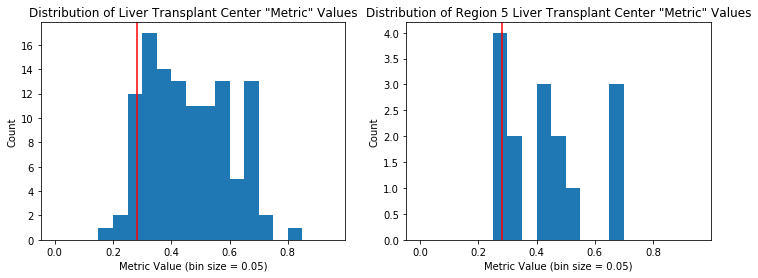

In [21]:
# plot distribution of Metric values
bins = np.arange(0, 1.0, 0.05)
fig, axes = plt.subplots(1,2,squeeze=False,figsize = (12,4))
plt.sca(axes[0,0])
plt.hist(data=liver_centers, x='Metric', bins=bins)
plt.title('Distribution of Liver Transplant Center "Metric" Values')
plt.xlabel('Metric Value (bin size = 0.05)')
plt.ylabel('Count')
casd_metric = liver_centers.loc['CASD','Metric']
plt.axvline(casd_metric, color='r')

# plot distribution for region 5 only
plt.sca(axes[0,1])
plt.hist(data=liver_centers[liver_centers.optn_region == 5], x='Metric', bins=bins)
plt.title('Distribution of Region 5 Liver Transplant Center "Metric" Values')
plt.xlabel('Metric Value (bin size = 0.05)')
plt.ylabel('Count')
plt.axvline(casd_metric, color='r');

The above histogram shows the distribution of liver transplant centers with the UCSD program shown in red. This metric was designed to assess the overall "success" of a transplant program based on one-year post transplant survival divided by all patients in the system. The formulation of this metric is described in detail in a separate document.

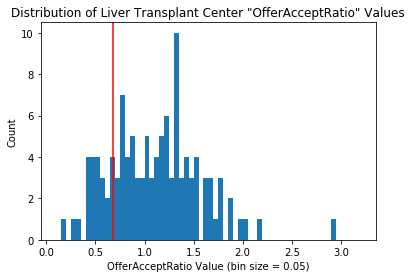

In [22]:
# plot distribution of OfferAcceptRatio values
bins = np.arange(0.1, liver_centers.OfferAcceptRatio.max()+0.01, 0.05)
plt.hist(data=liver_centers, x='OfferAcceptRatio', bins=bins)
plt.title('Distribution of Liver Transplant Center "OfferAcceptRatio" Values')
plt.xlabel('OfferAcceptRatio Value (bin size = 0.05)')
plt.ylabel('Count')
casd_OfferAcceptRatio = liver_centers.loc['CASD','OfferAcceptRatio']
plt.axvline(casd_OfferAcceptRatio, color='r');

The histogram of OfferAcceptRatio values shows the proportion of the donor organ offers presented to UCSD Liver Transplant that are accepted (the red vertical line) and where this program stands relative to the other liver transplant programs.

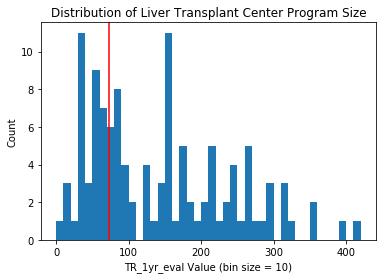

In [23]:
# plot distribution of transplants performed in 2017 as proxy for liver transplant program size 
bins = np.arange(0, liver_centers.TR_1yr_eval.max()+10, 10)
weights=np.ones(len(liver_centers.TR_1yr_eval)) / len(liver_centers.WL_xplant_2017)
plt.hist(data=liver_centers, x='TR_1yr_eval', bins=bins)
plt.title('Distribution of Liver Transplant Center Program Size')
plt.xlabel('TR_1yr_eval Value (bin size = 10)')
plt.ylabel('Count')
casd_WL_xplant_2017 = liver_centers.loc['CASD','TR_1yr_eval']
plt.axvline(casd_WL_xplant_2017, color='r');

### Bivariate EDA

Text(0, 0.5, 'Success Metric')

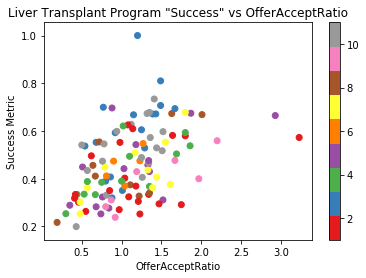

In [24]:
# Scatter plot OfferAcceptRatio against Metric distinguishing OPTN Regions by color
plt.scatter(data=liver_centers, x='OfferAcceptRatio', y='Metric', c='optn_region')
plt.colorbar()
plt.set_cmap('Set1')
plt.title('Liver Transplant Program "Success" vs OfferAcceptRatio')
plt.xlabel('OfferAcceptRatio')
plt.ylabel('Success Metric')


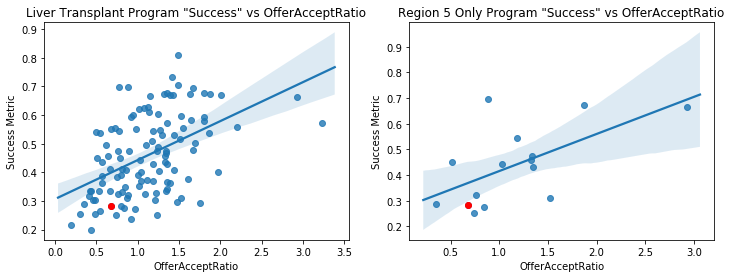

In [25]:
# Scatter plot OfferAcceptRatio against Metric
fig, axes = plt.subplots(1,2,squeeze=False,figsize = (12,4))
plt.sca(axes[0,0])
#plt.scatter(data=liver_centers[liver_centers.very_small == False], x='OfferAcceptRatio', y='Metric', c='WL_xplant_2017')
sb.regplot(data=liver_centers[(liver_centers.very_small == False)], x='OfferAcceptRatio', y='Metric')
plt.scatter(liver_centers.loc['CASD','OfferAcceptRatio'], liver_centers.loc['CASD','Metric'], color='red')
plt.title('Liver Transplant Program "Success" vs OfferAcceptRatio')
plt.xlabel('OfferAcceptRatio')
plt.ylabel('Success Metric')

# Scatter plot OfferAcceptRatio against Metric for region 5 only
plt.sca(axes[0,1])
sb.regplot(data=liver_centers[(liver_centers.very_small == False) & (liver_centers.optn_region == 5)], x='OfferAcceptRatio', y='Metric')
plt.scatter(liver_centers.loc['CASD','OfferAcceptRatio'], liver_centers.loc['CASD','Metric'], color='red')
plt.title('Region 5 Only Program "Success" vs OfferAcceptRatio')
plt.xlabel('OfferAcceptRatio')
plt.ylabel('Success Metric');

This scatter plot shows the OfferAcceptRatio on the x-axis and Metric of success on the y-axis. UCSD Liver Transplant is shown in red. In general outcomes metric appears to be correlated to OfferAcceptRatio.

In [26]:
# Calculate correlation coefficient between OfferAcceptRatio and Metric
print('Correlation between OfferAcceptRatio and Metric', liver_centers[(liver_centers.very_small == False)].Metric.corr(liver_centers.OfferAcceptRatio))
print('Region 5 only correlation between OfferAcceptRatio and Metric', liver_centers[(liver_centers.very_small == False) & (liver_centers.optn_region == 5)].Metric.corr(liver_centers.OfferAcceptRatio))

Correlation between OfferAcceptRatio and Metric 0.48216954048157556
Region 5 only correlation between OfferAcceptRatio and Metric 0.6073796476398959


The computed correlation coefficient value between OfferAcceptRatio and Metric values (0.48) indicates a significant correlation. The correlation coefficient considering only OPTN Region 5 is even more significant. While clearly there are other factors involved it appears from this evidence that OfferAcceptRatio might have a significant influence on program success.

(0, 4)

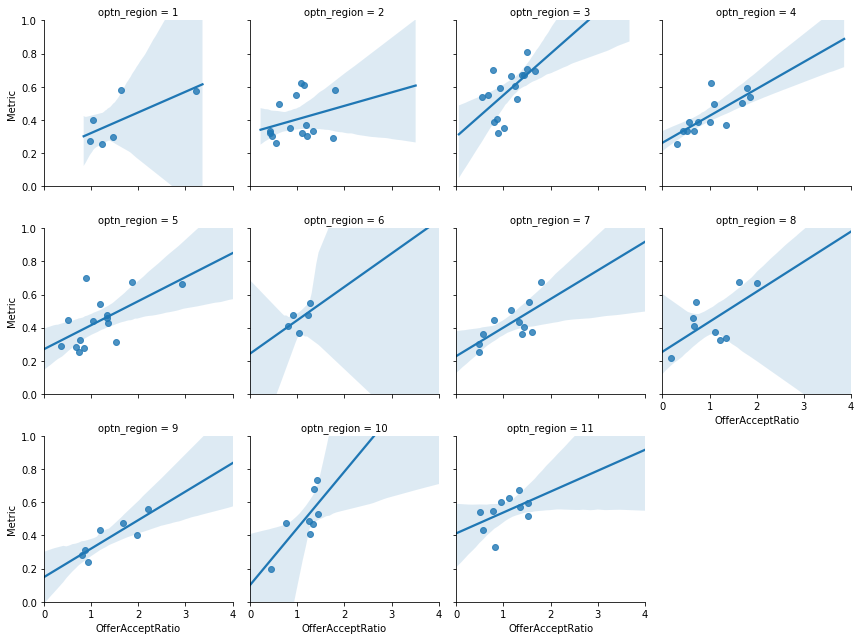

In [27]:
# Plot by region
g = sb.FacetGrid(data=liver_centers[(liver_centers.very_small == False) ], col='optn_region', col_wrap=4, height=3)
g = (g.map(sb.regplot, 'OfferAcceptRatio', 'Metric'))
plt.ylim(bottom=0, top=1)
plt.xlim(left=0, right=4)

This plot shows Metric vs OfferAcceptRatio on a region by region basis. The slope of the linear relation and accuracy of the fit varies from region to region but a positive correlation appears to be present in each.

Text(0, 0.5, 'Success Metric')

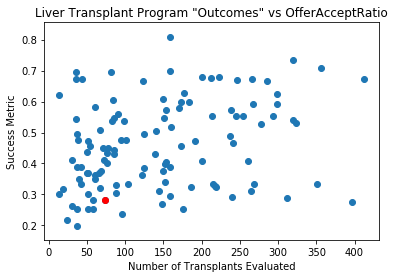

In [28]:
# scatter plot success metric vs program size
plt.scatter(data=liver_centers[(liver_centers.very_small == False)], x='TR_1yr_eval', y='Metric')
#sb.regplot(data=liver_centers[(liver_centers.very_small == False)], x='OfferAcceptRatio', y='Metric')
plt.set_cmap('viridis_r')
#plt.colorbar()
plt.scatter(liver_centers.loc['CASD','TR_1yr_eval'], liver_centers.loc['CASD','Metric'], color='red')
plt.title('Liver Transplant Program "Outcomes" vs OfferAcceptRatio')
plt.xlabel('Number of Transplants Evaluated')
plt.ylabel('Success Metric')

In [29]:
# Calculate correlation coefficient between TR_1yr_eval and Metric
print('Correlation between Number of Transplants Performed and Metric', liver_centers[(liver_centers.very_small == False)].Metric.corr(liver_centers.TR_1yr_eval))

Correlation between Number of Transplants Performed and Metric 0.29410661714128744


Visually there doesn't appear to be any significant correlation between program size and success metric and this is borne out by the calculated correlation coefficient.

In [30]:
liver_centers[['median_time_to_xplant','TR_meld_6-10','TR_meld_11-14','TR_meld_15-20','TR_meld_21-30','TR_meld_31-40','TR_status1A']].describe()

,TR_meld_15-20,TR_meld_21-30
count,116.000000,116.000000
mean,20.031897,23.368103
std,9.888549,8.503233
min,0.000000,0.000000
25%,13.675000,18.125000
50%,20.000000,23.250000
75%,25.000000,28.150000
max,51.700000,46.200000


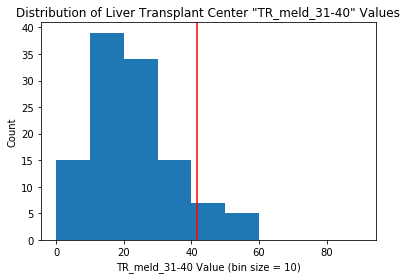

In [31]:
# Plot distribution of TR_meld_31-40 (percentage of transplant recepients with MELD of 31-40)
bins = np.arange(0, liver_centers['TR_meld_31-40'].max(), 10)
plt.hist(data=liver_centers, x='TR_meld_31-40', bins=bins)
plt.title('Distribution of Liver Transplant Center "TR_meld_31-40" Values')
plt.xlabel('TR_meld_31-40 Value (bin size = 10)')
plt.ylabel('Count')
casd_TR_meld_31_40 = liver_centers.loc['CASD','TR_meld_31-40']
plt.axvline(casd_TR_meld_31_40, color='r');

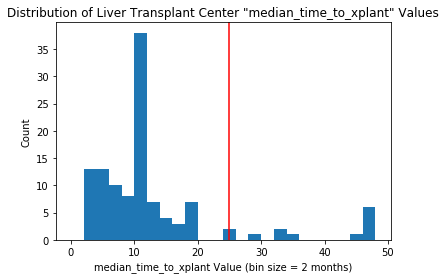

In [32]:
# Plot distribution of median_time_to_xplant (number of months between listing and transplant)
bins = np.arange(0, liver_centers['median_time_to_xplant'].max(), 2)
plt.hist(data=liver_centers, x='median_time_to_xplant', bins=bins)
plt.title('Distribution of Liver Transplant Center "median_time_to_xplant" Values')
plt.xlabel('median_time_to_xplant Value (bin size = 2 months)')
plt.ylabel('Count')
casd_median_time_to_xplant = liver_centers.loc['CASD','median_time_to_xplant']
plt.axvline(casd_median_time_to_xplant, color='r');

Text(0, 0.5, 'Success Metric')

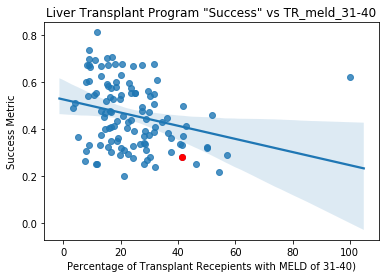

In [37]:
# scatter plot success metric vs TR_meld_31-40
#plt.scatter(data=liver_centers[(liver_centers.very_small == False)], x='TR_meld_31-40', y='Metric')
sb.regplot(data=liver_centers[(liver_centers.very_small == False)], x='TR_meld_31-40', y='Metric')
plt.set_cmap('viridis_r')
#plt.colorbar()
plt.scatter(liver_centers.loc['CASD','TR_meld_31-40'], liver_centers.loc['CASD','Metric'], color='red')
plt.title('Liver Transplant Program "Success" vs TR_meld_31-40')
plt.xlabel('Percentage of Transplant Recepients with MELD of 31-40)')
plt.ylabel('Success Metric')

(0, 60)

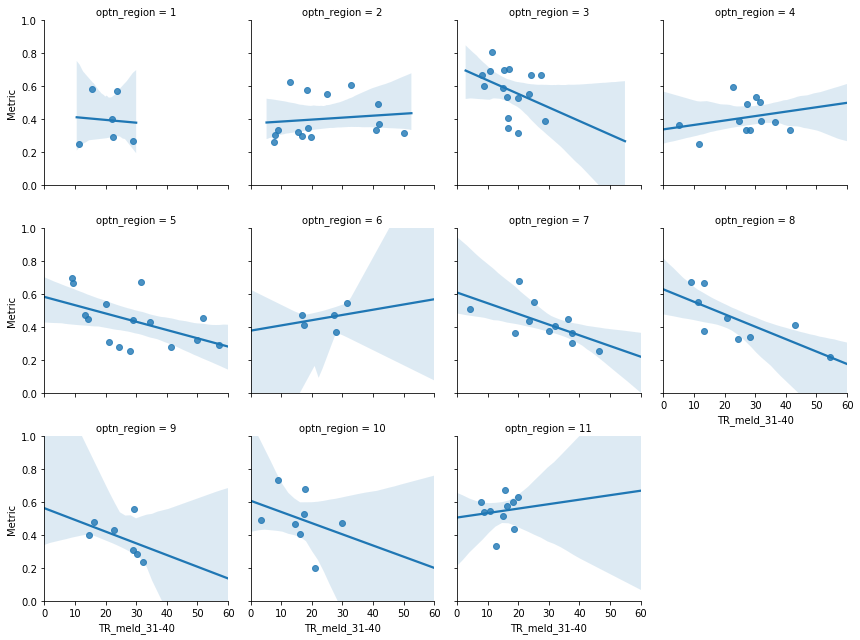

In [38]:
# Plot by region
g = sb.FacetGrid(data=liver_centers[(liver_centers.very_small == False)], col='optn_region', col_wrap=4, height=3)
g = (g.map(sb.regplot, 'TR_meld_31-40', 'Metric'))
plt.ylim(bottom=0, top=1)
plt.xlim(left=0, right=60)

Text(0, 0.5, 'Success Metric')

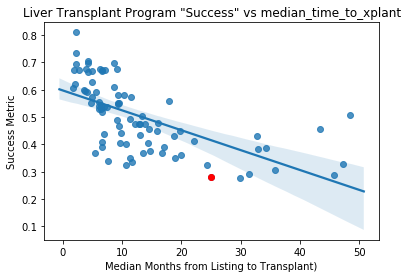

In [39]:
# scatter plot success metric vs median_time_to_xplant
#plt.scatter(data=liver_centers[(liver_centers.very_small == False)], x='TR_meld_31-40', y='Metric')
sb.regplot(data=liver_centers[(liver_centers.very_small == False) ], x='median_time_to_xplant', y='Metric')
plt.set_cmap('viridis_r')
#plt.colorbar()
plt.scatter(liver_centers.loc['CASD','median_time_to_xplant'], liver_centers.loc['CASD','Metric'], color='red')
plt.title('Liver Transplant Program "Success" vs median_time_to_xplant')
plt.xlabel('Median Months from Listing to Transplant)')
plt.ylabel('Success Metric')

(0, 50)

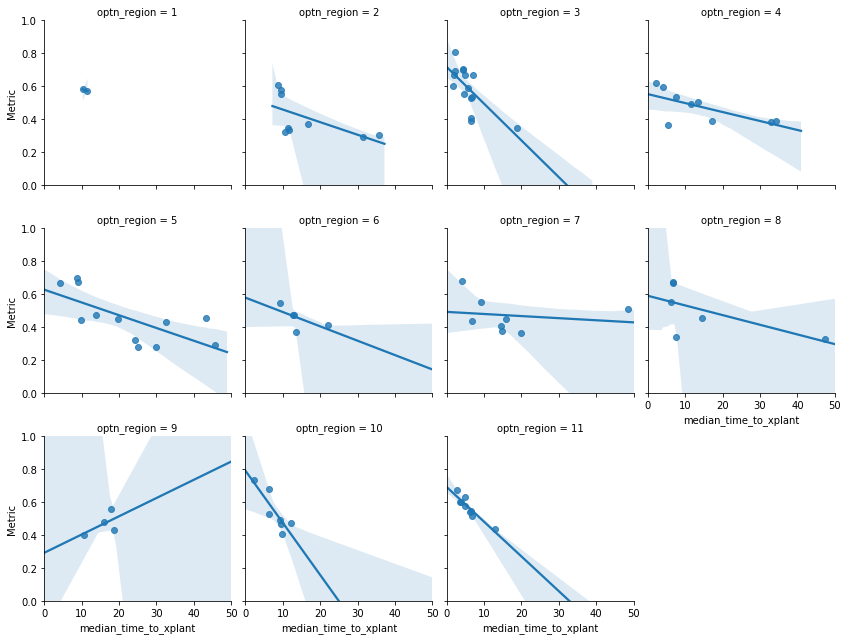

In [40]:
# Plot by region
g = sb.FacetGrid(data=liver_centers[(liver_centers.very_small == False) ], col='optn_region', col_wrap=4, height=3)
g = (g.map(sb.regplot, 'median_time_to_xplant', 'Metric'))
plt.ylim(bottom=0, top=1)
plt.xlim(left=0, right=50)

In [41]:
# compute correlation coefs for Metric, OfferAcceptRatio, TR_meld_31-40, median_time_to_xplant

liver_centers[['Metric','OfferAcceptRatio','TR_meld_31-40','median_time_to_xplant']].corr()

,Metric,OfferAcceptRatio,TR_meld_31-40,median_time_to_xplant
Metric,1.000000,0.459027,-0.301587,-0.607813
OfferAcceptRatio,0.459027,1.000000,-0.203776,-0.211936
TR_meld_31-40,-0.301587,-0.203776,1.000000,0.292496
median_time_to_xplant,-0.607813,-0.211936,0.292496,1.000000


In [42]:
liver_centers[liver_centers.median_time_to_xplant > 40.0][['CenterName','Metric','OfferAcceptRatio','TR_meld_31-40','median_time_to_xplant']]

,CenterName,Metric,OfferAcceptRatio,TR_meld_31-40,median_time_to_xplant
CACS,"""Cedars-Sinai Medical Center""",0.457992,1.33,51.8,43.4
CAUC,"""University of California at Los Angeles Medic...",0.289009,0.35,57.1,45.7
COUC,"""University of Colorado Hospital/Health Scienc...",0.327521,1.22,24.4,47.3
ILPL,"""Rush University Medical Center""",0.508671,1.17,4.2,48.4


## Regression Analysis

In this section regression models are applied to the data in an attempt to determine which variables best explain the Metric values

In [44]:
# median_time_to_xplant has some nan values that cause problems when fitting regression models so lets use a cleaned up version instead
liver_cntr_reg = liver_centers[(liver_centers.very_small == False) ][['Metric','OfferAcceptRatio','TR_meld_31-40','median_time_to_xplant','optn_region']].dropna()
liver_cntr_reg['intercept'] = 1
liver_cntr_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 86 entries, ALUA to WIUW
Data columns (total 6 columns):
Metric                   86 non-null float64
OfferAcceptRatio         86 non-null float64
TR_meld_31-40            86 non-null float64
median_time_to_xplant    86 non-null float64
optn_region              86 non-null int64
intercept                86 non-null int64
dtypes: float64(4), int64(2)
memory usage: 4.7+ KB


In [45]:
import statsmodels.api as sm

# add intercept column and fit an ordinary least squares (OLS) regression model
liver_centers['intercept'] = 1
lm = sm.OLS(liver_cntr_reg.Metric, liver_cntr_reg[['intercept','OfferAcceptRatio','median_time_to_xplant']])
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Metric   R-squared:                       0.429
Model:                            OLS   Adj. R-squared:                  0.416
Method:                 Least Squares   F-statistic:                     31.21
Date:                Mon, 09 Sep 2019   Prob (F-statistic):           7.80e-11
Time:                        12:44:51   Log-Likelihood:                 80.046
No. Observations:                  86   AIC:                            -154.1
Df Residuals:                      83   BIC:                            -146.7
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 0.5222      0.035     15.113      0.000       0.453       0.591
OfferAcceptRatio          0.0552      0.022      2.486      0.015       0.011       0.099
median_time_to_xplant    -0.0068      0.001     -6.794      0.000      -0.009      -0.005
==============================================================================
Omnibus:                        0.102   Durbin-Watson:                   1.575
Prob(Omnibus):                  0.950   Jarque-Bera (JB):                0.257
Skew:                           0.059   Prob(JB):                        0.879
Kurtosis:                       2.760   Cond. No.                         64.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
# add dummy variables, one for each region but omit one (region 11)
### Create the necessary dummy variables
liver_cntr_reg[['region_1','region_2','region_3','region_4','region_5','region_6','region_7','region_8','region_9','region_10','region_11']]=pd.get_dummies(liver_cntr_reg['optn_region'])
liver_cntr_reg.head()

,Metric,OfferAcceptRatio,TR_meld_31-40,median_time_to_xplant,optn_region,intercept,region_1,region_2,region_3,region_4,region_5,region_6,region_7,region_8,region_9,region_10,region_11
ALUA,0.592900,0.92,15.1,5.6,3,1,0,0,1,0,0,0,0,0,0,0,0
ARUA,0.536996,0.54,16.2,6.9,3,1,0,0,1,0,0,0,0,0,0,0,0
AZGS,0.674472,1.87,31.7,9.1,5,1,0,0,0,0,1,0,0,0,0,0,0
AZMC,0.664804,2.93,9.4,4.2,5,1,0,0,0,0,1,0,0,0,0,0,0
AZSJ,0.696518,0.88,9.1,8.7,5,1,0,0,0,0,1,0,0,0,0,0,0


In [47]:
lm_region = sm.OLS(liver_cntr_reg.Metric, liver_cntr_reg[['intercept','OfferAcceptRatio','region_1','region_2','region_3','region_4','region_5','region_6','region_7','region_8','region_9','region_10']])
results = lm_region.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Metric   R-squared:                       0.394
Model:                            OLS   Adj. R-squared:                  0.304
Method:                 Least Squares   F-statistic:                     4.372
Date:                Mon, 09 Sep 2019   Prob (F-statistic):           4.93e-05
Time:                        12:45:31   Log-Likelihood:                 77.462
No. Observations:                  86   AIC:                            -130.9
Df Residuals:                      74   BIC:                            -101.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
intercept            0.4360      0.046      9.533      0.000       0.345       0.527
OfferAcceptRatio     0.1232      0.027      4.533      0.000       0.069       0.177
region_1            -0.1587      0.091     -1.748      0.085      -0.340       0.022
region_2            -0.1783      0.050     -3.550      0.001      -0.278      -0.078
region_3             0.0189      0.045      0.423      0.673      -0.070       0.108
region_4            -0.1127      0.050     -2.246      0.028      -0.213      -0.013
region_5            -0.1231      0.047     -2.630      0.010      -0.216      -0.030
region_6            -0.1096      0.059     -1.855      0.068      -0.227       0.008
region_7            -0.1353      0.052     -2.591      0.012      -0.239      -0.031
region_8            -0.0881      0.056     -1.570      0.121      -0.200       0.024
region_9            -0.1861      0.066     -2.803      0.006      -0.318      -0.054
region_10           -0.0516      0.054     -0.961      0.340      -0.158       0.055
==============================================================================
Omnibus:                        0.558   Durbin-Watson:                   1.736
Prob(Omnibus):                  0.757   Jarque-Bera (JB):                0.561
Skew:                           0.185   Prob(JB):                        0.755
Kurtosis:                       2.859   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [48]:
# Fit linear model with OfferAcceptRatio, optn_region and median_time_to_xplant
lm_region_mttx = sm.OLS(liver_cntr_reg.Metric, liver_cntr_reg[['intercept','OfferAcceptRatio','median_time_to_xplant','region_1','region_2','region_3','region_4','region_5','region_6','region_7','region_8','region_9','region_10']])
results = lm_region_mttx.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Metric   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.441
Method:                 Least Squares   F-statistic:                     6.593
Date:                Mon, 09 Sep 2019   Prob (F-statistic):           7.94e-08
Time:                        12:45:36   Log-Likelihood:                 87.501
No. Observations:                  86   AIC:                            -149.0
Df Residuals:                      73   BIC:                            -117.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
intercept                 0.5087      0.044     11.507      0.000       0.421       0.597
OfferAcceptRatio          0.0835      0.026      3.216      0.002       0.032       0.135
median_time_to_xplant    -0.0052      0.001     -4.381      0.000      -0.008      -0.003
region_1                 -0.0778      0.083     -0.933      0.354      -0.244       0.088
region_2                 -0.1169      0.047     -2.481      0.015      -0.211      -0.023
region_3                  0.0198      0.040      0.496      0.622      -0.060       0.100
region_4                 -0.0620      0.046     -1.336      0.186      -0.154       0.031
region_5                 -0.0341      0.047     -0.732      0.467      -0.127       0.059
region_6                 -0.0670      0.054     -1.244      0.217      -0.174       0.040
region_7                 -0.0661      0.049     -1.338      0.185      -0.164       0.032
region_8                 -0.0336      0.052     -0.648      0.519      -0.137       0.070
region_9                 -0.1066      0.062     -1.714      0.091      -0.230       0.017
region_10                -0.0332      0.048     -0.688      0.494      -0.129       0.063
==============================================================================
Omnibus:                        0.058   Durbin-Watson:                   1.782
Prob(Omnibus):                  0.972   Jarque-Bera (JB):                0.211
Skew:                           0.038   Prob(JB):                        0.900
Kurtosis:                       2.770   Cond. No.                         199.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""